In [59]:
# import the necessary packages
import numpy as np
import cv2
from matplotlib import pyplot as plt
import imutils

In [60]:
from os import listdir
from os.path import isfile, join
images_paths = sorted([f for f in listdir('../images') if isfile(join('../images', f))])

In [61]:
def bound_box(image_path):
    # load the image and convert it to grayscale
    image = cv2.imread(image_path)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    """print(image.shape)
    plt.imshow(gray, 'gray')"""

    # Find contours
    kernel_horizontal_derivative = 1/4 * np.array([[-1,0,1], [-2,0,2], [-1,0,1]])
    image_horizontal_derivative = cv2.filter2D(gray, -1, kernel_horizontal_derivative)
    image_horizontal_derivative = np.abs(image_horizontal_derivative)
    kernel_vertical_derivative = 1/4 * np.array([[-1,-2,-1], [0,0,0], [1,2,1]])
    image_vertical_derivative = cv2.filter2D(gray, -1, kernel_vertical_derivative)
    image_vertical_derivative = np.abs(image_vertical_derivative)

    image_derivative = np.maximum(image_horizontal_derivative, image_vertical_derivative)

    """plt.figure()
    plt.imshow(image_horizontal_derivative, 'gray')"""
    
    ret2,thresh = cv2.threshold(image_horizontal_derivative,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    
    kernel = cv2.getStructuringElement(cv2.MORPH_CROSS, (20, 20))
    closed0 = cv2.morphologyEx(thresh, cv2.MORPH_CLOSE, kernel)
    
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1, 100))
    opened = cv2.morphologyEx(closed0, cv2.MORPH_OPEN, kernel)
    
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (50, 1))
    closed = cv2.morphologyEx(opened, cv2.MORPH_CLOSE, kernel)
    
    #kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (20, 1))
    #opened1 = cv2.morphologyEx(closed, cv2.MORPH_OPEN, kernel)
    
    kernel = np.zeros((11,11),np.uint8)
    kernel[5,:] = 1
    dilated = cv2.dilate(closed, kernel, iterations = 5)
    
    cnts = cv2.findContours(dilated.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    #print(cnts)
    cnts = imutils.grab_contours(cnts)
    c = sorted(cnts, key = cv2.contourArea, reverse = True)[0]
    # compute the rotated bounding box of the largest contour
    rect = cv2.minAreaRect(c)
    #print(rect)
    box = cv2.cv.BoxPoints(rect) if imutils.is_cv2() else cv2.boxPoints(rect)
    box = np.int0(box)
    #print(box)
    # draw a bounding box arounded the detected barcode and display the
    # image
    image_bb = image.copy()
    cv2.drawContours(image_bb, [box], -1, (0, 255, 0), 3)
    plt.figure()
    plt.imshow(image_bb, 'gray')
    
    coordinates_source = box.astype('float32')
    min_width = coordinates_source[:,0].min()
    min_height = coordinates_source[:,1].min()
    max_width = coordinates_source[:,0].max()
    max_height = coordinates_source[:,1].max()
    def normalize(value, axis=0):
        if axis==0:  # Horizontal dimension
            return min_width if (value-min_width<max_width-value) \
                             else max_width
        elif axis==1:  # Vertical dimension
            return min_height if (value-min_height<max_height-value) \
                              else max_height
    coordinates_source = np.array(sorted([tuple(v) for v in coordinates_source], key=lambda t: (normalize(t[1], axis=1),
                                                                                                normalize(t[0], axis=0))))
    print(coordinates_source)
    def dist(point1, point2):
        return np.sqrt(np.sum((point1-point2)**2))
    destination_height = int(max([dist(coordinates_source[0],coordinates_source[2]),
                             dist(coordinates_source[1],coordinates_source[3])]))
    destination_width = int(max([dist(coordinates_source[0],coordinates_source[1]),
                             dist(coordinates_source[2],coordinates_source[3])]))
    coordinates_destination = np.array([[0, 0],
                                        [destination_width-1, 0],
                                        [0, destination_height-1],
                                        [destination_width-1, destination_height-1]], dtype='float32')
    # Computing the trasformation, i.e. homography. Warping.
    H = cv2.getPerspectiveTransform(coordinates_source, coordinates_destination)
    # Applying the trasformation
    gray1 = cv2.warpPerspective(gray, H, (destination_width, destination_height))
    plt.figure()
    plt.imshow(gray1, 'gray')

[[ 403.  261.]
 [1299.  257.]
 [ 408. 1131.]
 [1303. 1127.]]
Wall time: 94.9 ms


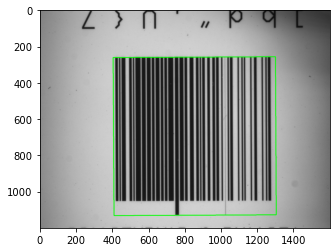

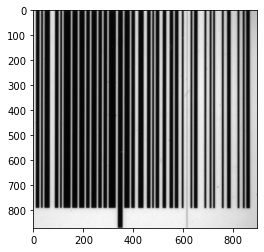

In [62]:
%%time
bound_box(f'../images/{images_paths[0]}')

[[ 352.  288.]
 [1252.  288.]
 [ 352. 1084.]
 [1252. 1084.]]
Wall time: 101 ms


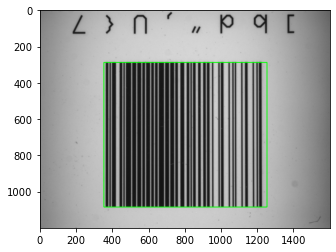

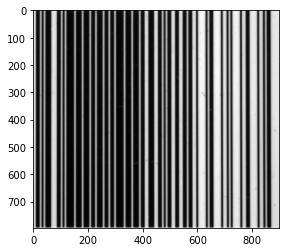

In [63]:
%%time
bound_box(f'../images/{images_paths[1]}')

[[ 201.  243.]
 [1047.  237.]
 [ 205.  766.]
 [1051.  760.]]
Wall time: 70.3 ms


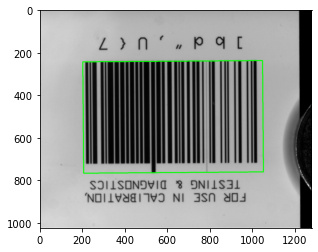

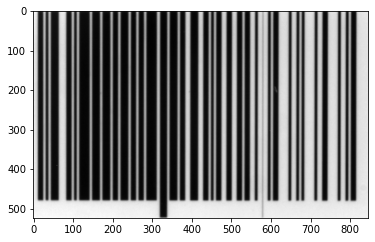

In [64]:
%%time
bound_box(f'../images/{images_paths[2]}')

[[131. 258.]
 [977. 258.]
 [131. 740.]
 [977. 740.]]
Wall time: 117 ms


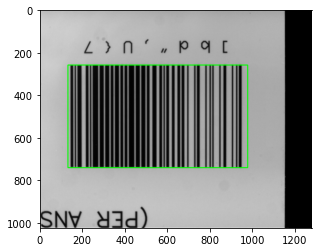

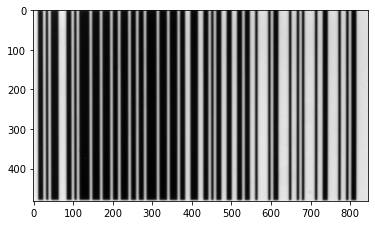

In [65]:
%%time
bound_box(f'../images/{images_paths[3]}')

[[329. 172.]
 [909. 172.]
 [329. 731.]
 [909. 731.]]
Wall time: 68.6 ms


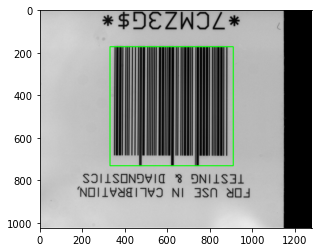

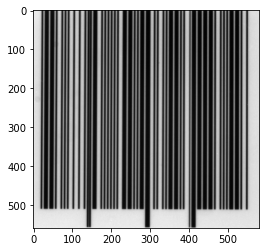

In [66]:
%%time
bound_box(f'../images/{images_paths[4]}')

[[335. 251.]
 [918. 251.]
 [335. 764.]
 [918. 764.]]


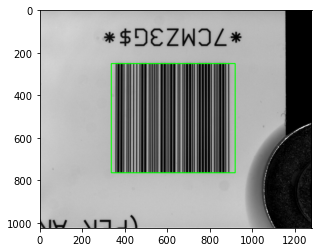

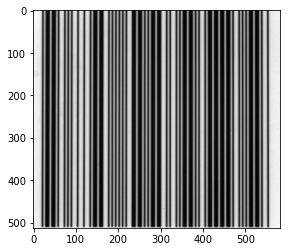

In [67]:
bound_box(f'../images/{images_paths[5]}')

[[ 159.  288.]
 [1107.  285.]
 [ 161.  847.]
 [1108.  845.]]


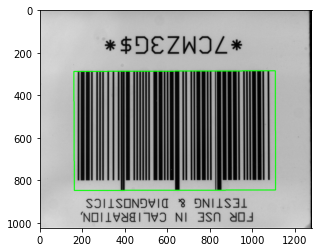

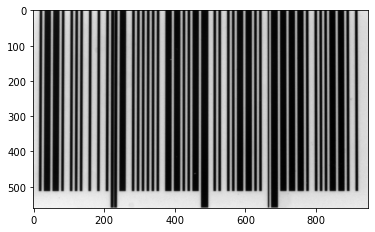

In [68]:
bound_box(f'../images/{images_paths[6]}')

[[ 146.  274.]
 [1098.  276.]
 [ 145.  788.]
 [1097.  789.]]


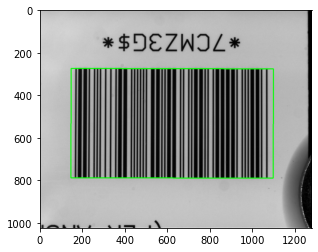

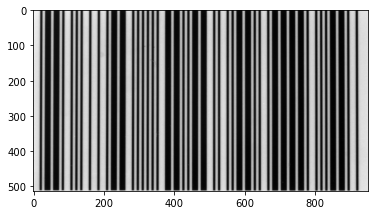

In [69]:
bound_box(f'../images/{images_paths[7]}')

[[326. 335.]
 [981. 340.]
 [322. 778.]
 [977. 784.]]


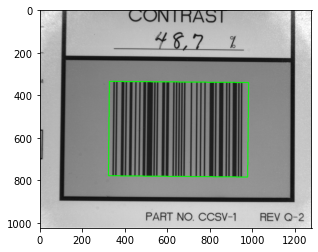

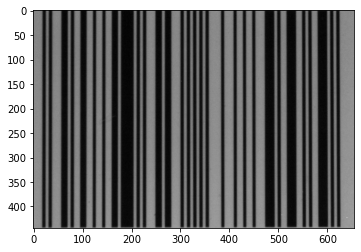

In [70]:
bound_box(f'../images/{images_paths[8]}')

[[338. 255.]
 [987. 263.]
 [332. 719.]
 [981. 728.]]


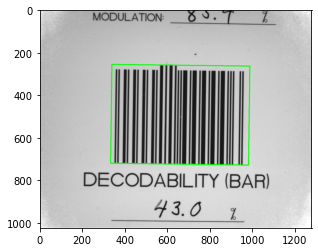

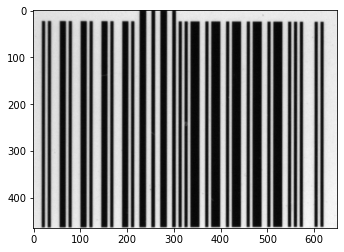

In [71]:
bound_box(f'../images/{images_paths[9]}')

In [72]:
print(f'../images/{images_paths[10]}')

images/EAN-UPC-DEFECTS IMGB.BMP


In [73]:
#bound_box(f'../images/{images_paths[10]}')

[[262. 284.]
 [962. 282.]
 [263. 756.]
 [963. 755.]]


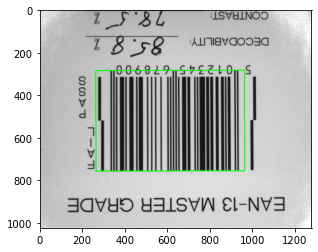

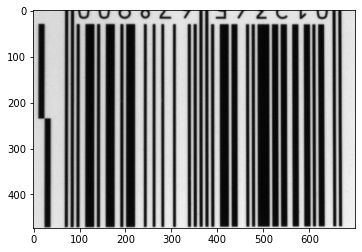

In [74]:
bound_box(f'../images/{images_paths[11]}')

In [75]:
#bound_box(f'../images/{images_paths[12]}')

[[ 100.  118.]
 [1302.  120.]
 [  99.  310.]
 [1301.  312.]]


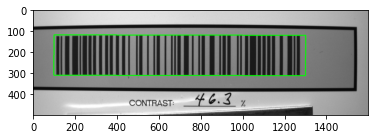

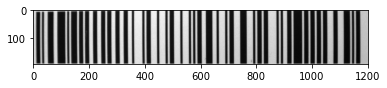

In [76]:
bound_box(f'../images/{images_paths[13]}')

[[ 164.  146.]
 [1359.  146.]
 [ 164.  336.]
 [1359.  336.]]


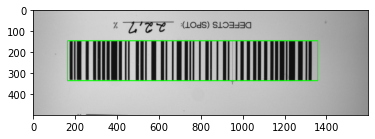

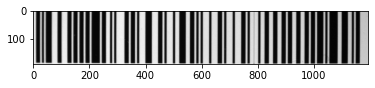

In [77]:
bound_box(f'../images/{images_paths[14]}')

[[ 179.  151.]
 [1392.  143.]
 [ 181.  359.]
 [1393.  352.]]


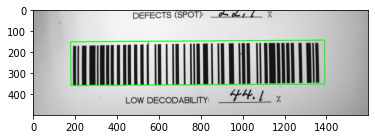

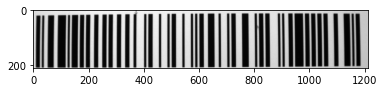

In [78]:
bound_box(f'../images/{images_paths[15]}')

[[ 202.  141.]
 [1399.  141.]
 [ 202.  331.]
 [1399.  331.]]


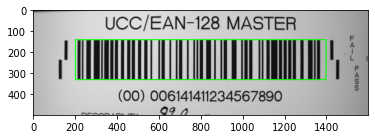

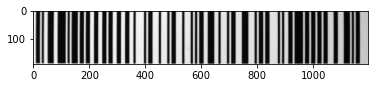

In [79]:
bound_box(f'../images/{images_paths[16]}')

[[ 193.  145.]
 [1359.  126.]
 [ 197.  384.]
 [1363.  365.]]


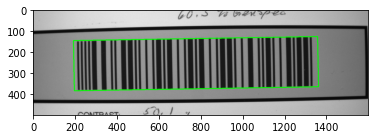

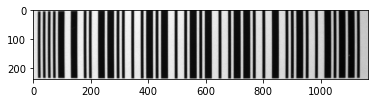

In [80]:
bound_box(f'../images/{images_paths[17]}')

[[ 197.  123.]
 [1366.  123.]
 [ 197.  367.]
 [1366.  367.]]


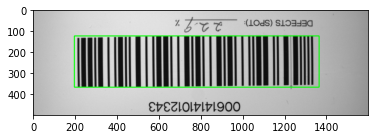

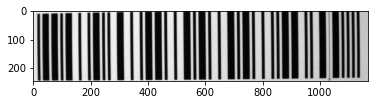

In [81]:
bound_box(f'../images/{images_paths[18]}')

[[ 228.   59.]
 [1393.   59.]
 [ 228.  297.]
 [1393.  297.]]


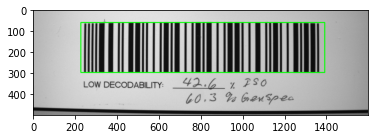

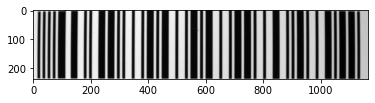

In [82]:
bound_box(f'../images/{images_paths[19]}')

[[ 245.  142.]
 [1415.  130.]
 [ 248.  381.]
 [1417.  370.]]


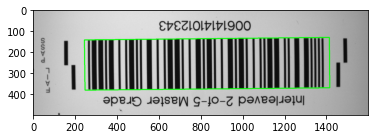

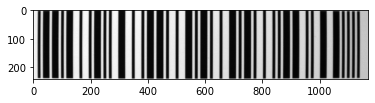

In [83]:
bound_box(f'../images/{images_paths[20]}')

In [84]:
print(f'../images/{images_paths[21]}')

images/TestChart.xls


In [85]:
#bound_box(f'../images/{images_paths[21]}')

[[191. 212.]
 [895. 209.]
 [193. 642.]
 [897. 639.]]


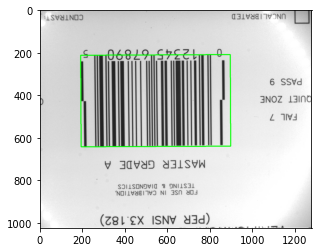

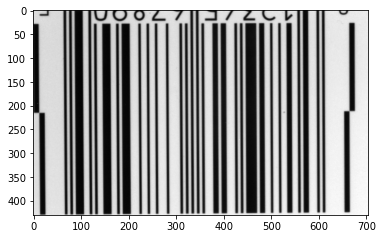

In [86]:
bound_box(f'../images/{images_paths[22]}')

[[308. 306.]
 [904. 311.]
 [305. 735.]
 [900. 740.]]


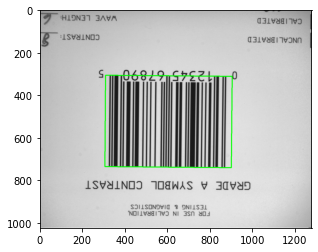

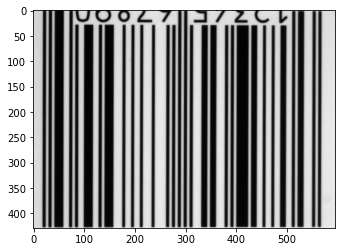

In [87]:
bound_box(f'../images/{images_paths[23]}')

[[342. 301.]
 [935. 311.]
 [335. 731.]
 [928. 741.]]


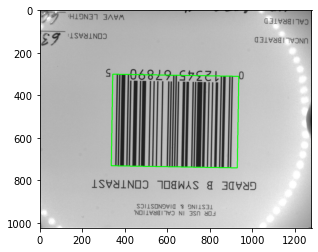

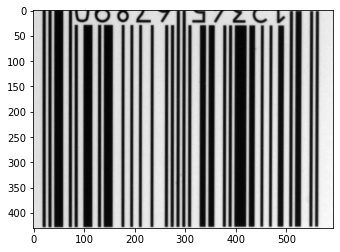

In [88]:
bound_box(f'../images/{images_paths[24]}')

[[349. 304.]
 [943. 306.]
 [347. 733.]
 [942. 736.]]


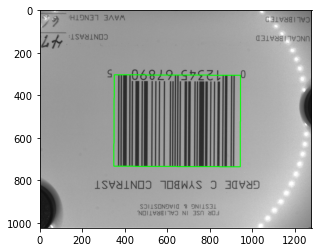

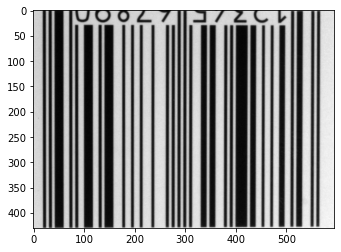

In [89]:
bound_box(f'../images/{images_paths[25]}')

[[290. 279.]
 [883. 300.]
 [274. 710.]
 [867. 732.]]


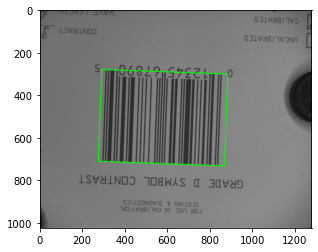

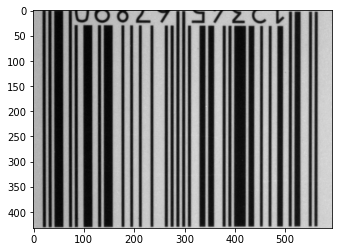

In [90]:
bound_box(f'../images/{images_paths[26]}')

[[326. 291.]
 [919. 301.]
 [318. 721.]
 [912. 731.]]


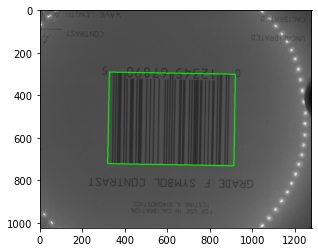

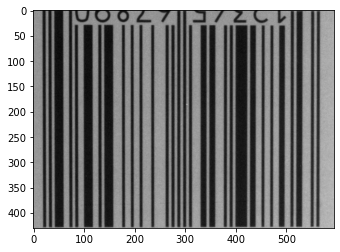

In [91]:
bound_box(f'../images/{images_paths[27]}')

[[320. 295.]
 [915. 303.]
 [315. 726.]
 [910. 733.]]


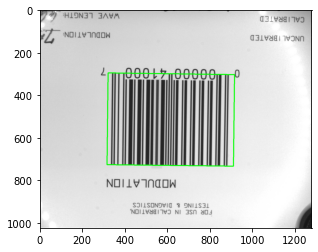

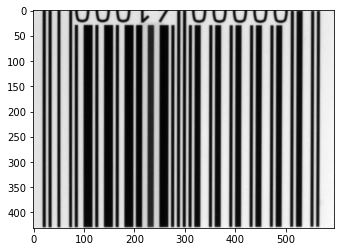

In [92]:
bound_box(f'../images/{images_paths[28]}')

[[320. 301.]
 [915. 310.]
 [313. 731.]
 [908. 741.]]


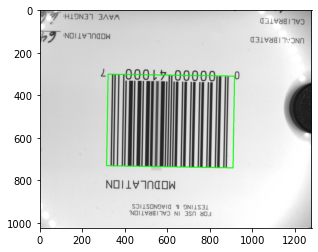

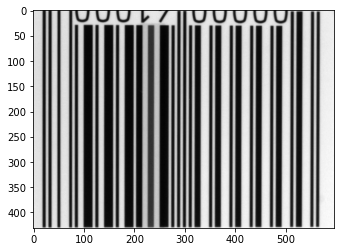

In [93]:
bound_box(f'../images/{images_paths[29]}')

[[317. 310.]
 [912. 322.]
 [309. 742.]
 [904. 753.]]


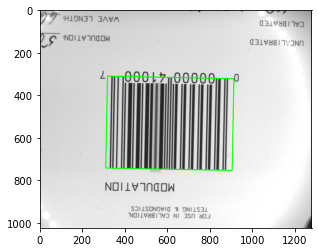

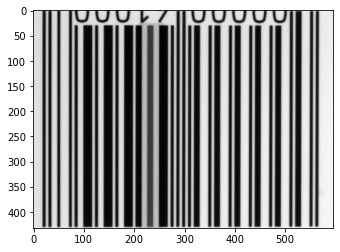

In [94]:
bound_box(f'../images/{images_paths[30]}')

[[325. 300.]
 [919. 316.]
 [313. 730.]
 [907. 747.]]


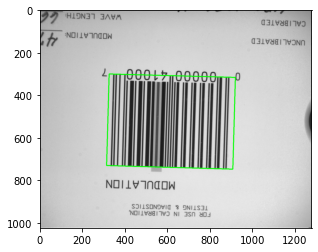

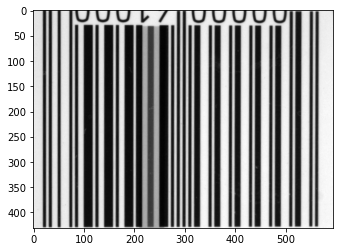

In [95]:
bound_box(f'../images/{images_paths[31]}')

[[327. 292.]
 [921. 292.]
 [327. 722.]
 [921. 722.]]


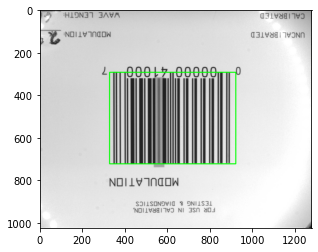

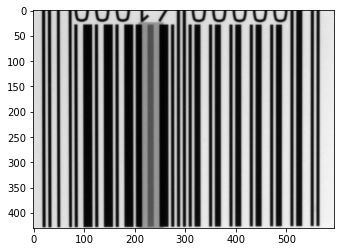

In [96]:
bound_box(f'../images/{images_paths[32]}')

[[338. 298.]
 [933. 304.]
 [334. 750.]
 [928. 756.]]


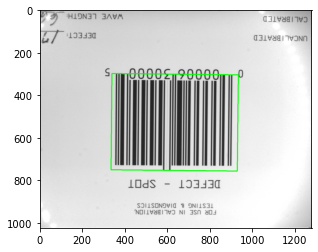

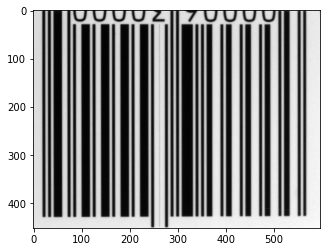

In [97]:
bound_box(f'../images/{images_paths[34]}')

[[338. 289.]
 [932. 298.]
 [331. 739.]
 [926. 748.]]


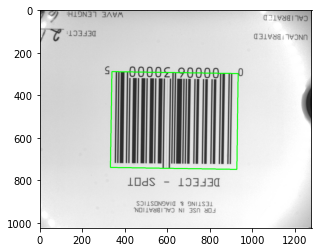

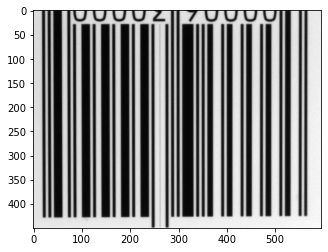

In [98]:
bound_box(f'../images/{images_paths[35]}')

[[326. 294.]
 [919. 294.]
 [326. 745.]
 [919. 745.]]


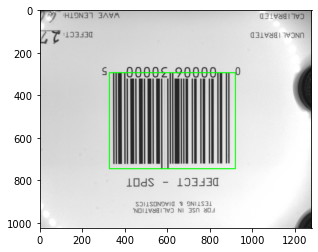

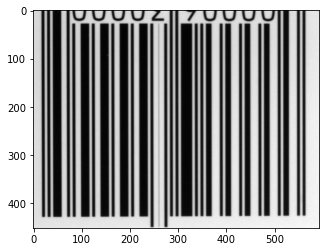

In [99]:
bound_box(f'../images/{images_paths[36]}')

[[312. 299.]
 [906. 300.]
 [312. 751.]
 [906. 751.]]


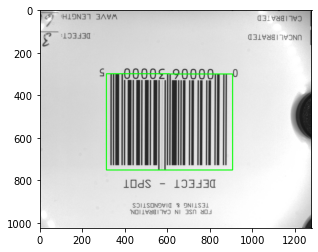

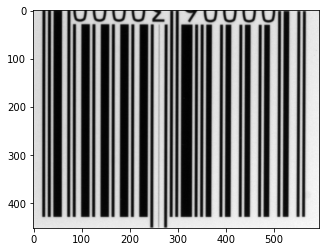

In [100]:
bound_box(f'../images/{images_paths[37]}')

[[324. 300.]
 [920. 303.]
 [322. 750.]
 [918. 753.]]


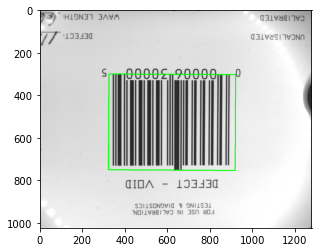

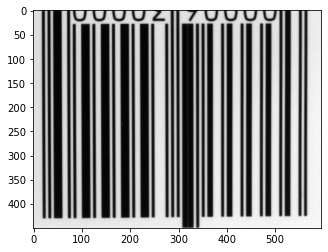

In [101]:
bound_box(f'../images/{images_paths[38]}')

[[328. 292.]
 [924. 300.]
 [323. 744.]
 [918. 751.]]


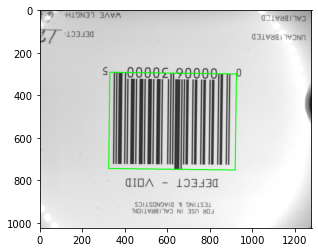

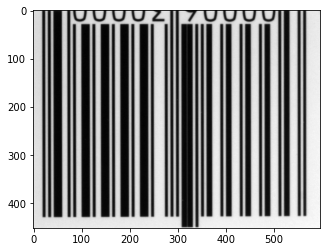

In [102]:
bound_box(f'../images/{images_paths[39]}')

[[292. 302.]
 [887. 305.]
 [290. 754.]
 [885. 757.]]


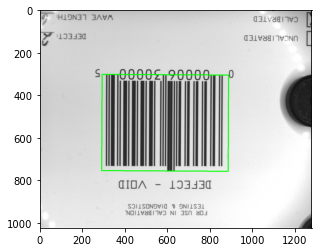

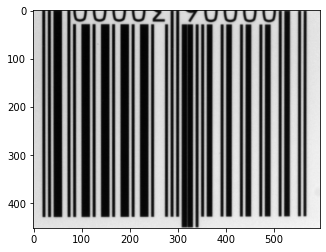

In [103]:
bound_box(f'../images/{images_paths[40]}')

[[282. 296.]
 [878. 294.]
 [283. 745.]
 [879. 744.]]


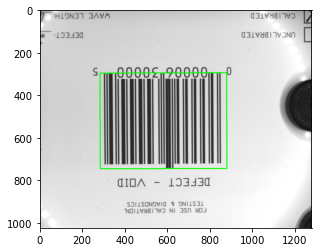

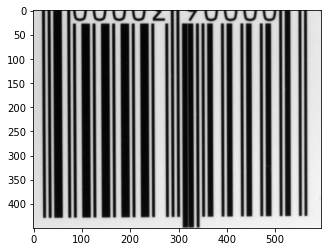

In [104]:
bound_box(f'../images/{images_paths[41]}')

[[280. 293.]
 [875. 293.]
 [280. 744.]
 [875. 744.]]


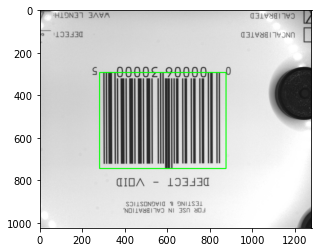

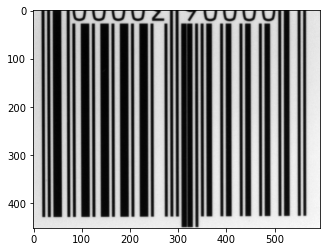

In [105]:
bound_box(f'../images/{images_paths[42]}')

[[274. 288.]
 [869. 288.]
 [274. 718.]
 [869. 718.]]


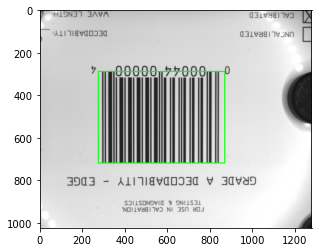

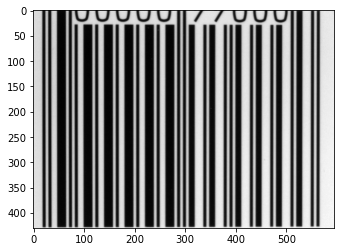

In [106]:
bound_box(f'../images/{images_paths[43]}')

[[284. 293.]
 [879. 296.]
 [281. 724.]
 [877. 727.]]


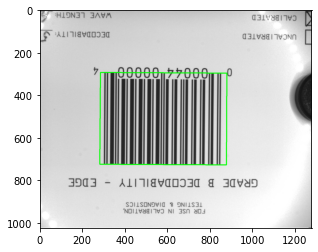

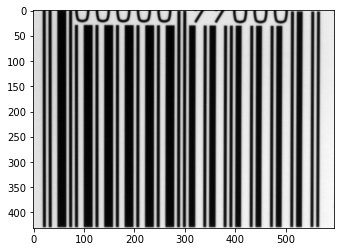

In [107]:
bound_box(f'../images/{images_paths[44]}')

[[273. 306.]
 [868. 309.]
 [271. 736.]
 [866. 739.]]


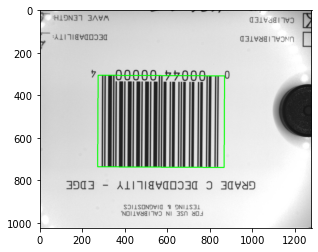

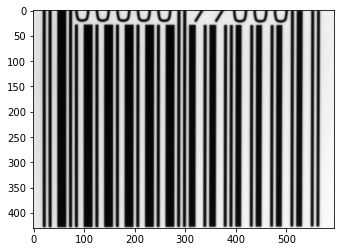

In [108]:
bound_box(f'../images/{images_paths[45]}')

[[257. 294.]
 [853. 302.]
 [251. 725.]
 [847. 733.]]


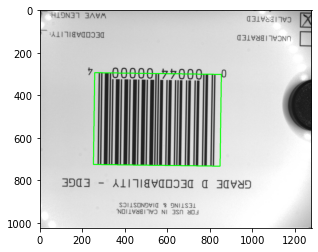

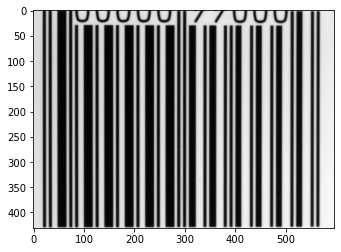

In [109]:
bound_box(f'../images/{images_paths[46]}')

[[251. 303.]
 [848. 307.]
 [248. 733.]
 [844. 738.]]


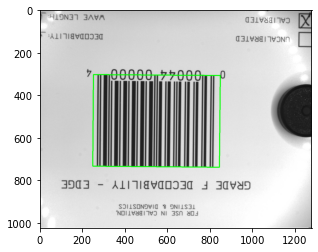

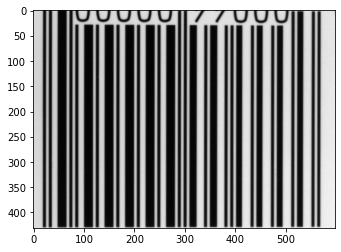

In [110]:
bound_box(f'../images/{images_paths[47]}')

[[246. 301.]
 [842. 308.]
 [240. 732.]
 [837. 739.]]


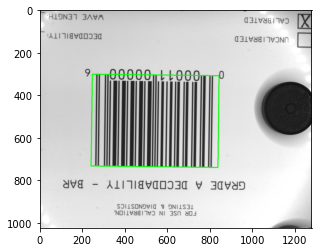

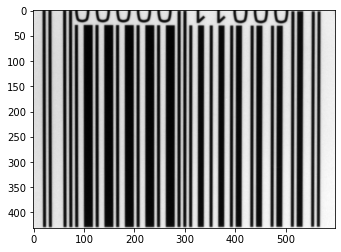

In [111]:
bound_box(f'../images/{images_paths[48]}')

[[250. 301.]
 [846. 308.]
 [244. 733.]
 [841. 740.]]


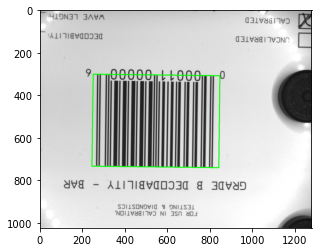

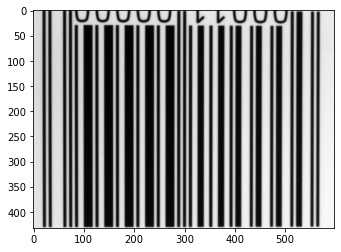

In [112]:
bound_box(f'../images/{images_paths[49]}')

[[274. 279.]
 [870. 287.]
 [269. 710.]
 [864. 717.]]


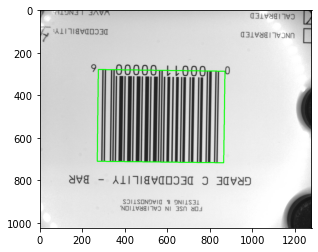

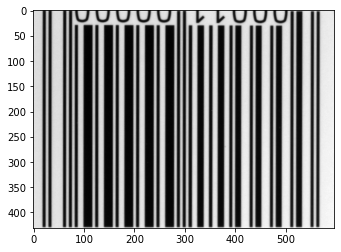

In [113]:
bound_box(f'../images/{images_paths[50]}')

[[276. 289.]
 [872. 297.]
 [270. 720.]
 [866. 728.]]


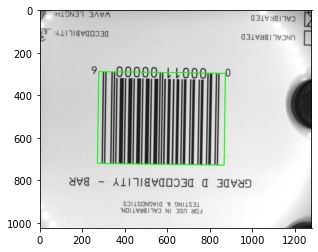

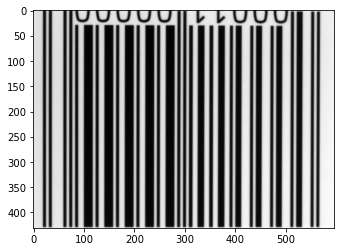

In [114]:
bound_box(f'../images/{images_paths[51]}')

[[289. 292.]
 [884. 293.]
 [289. 722.]
 [884. 722.]]


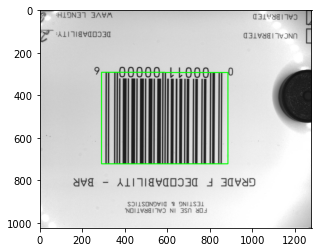

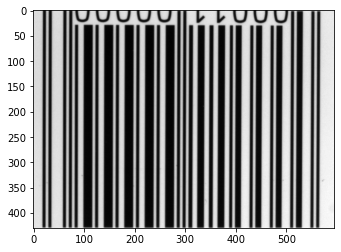

In [115]:
bound_box(f'../images/{images_paths[52]}')

[[213.  42.]
 [268.  43.]
 [213. 150.]
 [268. 150.]]
Wall time: 32.1 ms


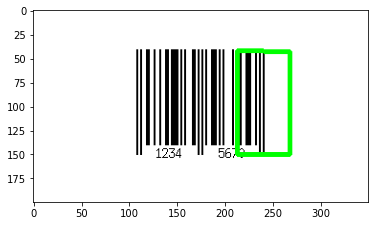

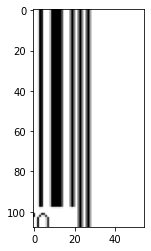

In [116]:
%%time
bound_box('other images/1.png')